# Technical note: Simulation with sensitivities test case

## Repeated bolus infusion with linear clearance

In this notebook we model the drug amount in a compartment with a linear clearance rate

\begin{equation}
    \frac{\text{d}a}{\text{d}t} = -ka + r_{\text{dose}}(t),
\end{equation}

where $a$ is the amount of drug in the compartment, $k$ is the elimination rate and $r_{\text{dose}}$ is the dose rate. This simple model reduces to a exponential decay, where the the bolus infusions update the amount in the compartment over time. The analytic solution to this problem is given by

\begin{equation}
    a(t) = a_0 \textrm{e} ^{ -k t } + \int _0^t \text{d}t'\, r_{\text{dose}}(t') \textrm{e} ^{ -k (t-t') }.
\end{equation}

Here $a_0$ is the initial drug in the compartment. The first term represents the linear clearance of the initial drug amount, while the second term is the linear clearance of the injected drug amount at later times.

The partial derivatives of this model can be straightforwardly computed to be

\begin{equation}
    \frac{\partial a}{\partial a_0} = \textrm{e} ^{ -k t } \quad \text{and} \quad \frac{\partial a}{\partial k} = -t\, a_0 \textrm{e} ^{ -k t} - \int _0^t \text{d}t'\, (t-t')\, r_{\text{dose}}(t') \textrm{e} ^{ -k (t-t') }.
\end{equation}

## Build model

In [1]:
import myokit

model = myokit.Model()
comp = model.add_component('myokit')

# Add state, parameters and time and pace bound variables
amount = comp.add_variable('amount')
time = comp.add_variable('time')
dose_rate = comp.add_variable('dose_rate')
elimination_rate = comp.add_variable('elimination_rate')

# Bound variables
time.set_binding('time')
dose_rate.set_binding('pace')

# Assign rhs
amount.promote(10)
amount.set_rhs(
    myokit.Minus(
        myokit.Name(dose_rate),
        myokit.Multiply(
            myokit.Name(elimination_rate),
            myokit.Name(amount))))
elimination_rate.set_rhs(myokit.Number(1))
time.set_rhs(myokit.Number(0))
dose_rate.set_rhs(myokit.Number(0))

## Solve model analytically

For a bolus dosing schedule that periodically administers an infusion at rate $r$ over some duration $\Delta t$, the time dependent dose rate can be expressed by a sum of step functions functions

\begin{equation}
    r_{\text{dose}}(t) = r \sum _{i=0}^{\infty} \theta (t - i) \theta (\Delta t + i - t),
\end{equation}

where for simplicity we assume that the periodicity of the infusions is 1. The analytical solution then takes the form

\begin{equation}
    a(t) = a_0 \textrm{e} ^{ -k t } + r\sum _{i=0}^{n(t)} \left( b(t, i) \textrm{e} ^{ -k(t-i-\Delta t)} - \textrm{e} ^{ -k(t-i)}\right) = 
    a_0 \textrm{e} ^{ -k t } + \left\lbrace \begin{matrix} 
        a_{\infty}^{\text{max}}\left( \textrm{e} ^{ -k(\Delta t_{\text{last}}+1) } - \textrm{e} ^{ -k(t - \Delta t + 1) }\right) + \frac{r}{k} \left( 1 - \textrm{e} ^{ -k (\Delta t_{\text{last}} + \Delta t)}\right)& \quad \text{for} \quad \Delta t_{\text{last}} < \Delta t \\ 
        a_{\infty}^{\text{max}}\left( \textrm{e} ^{ -k\Delta t_{\text{last}} } - \textrm{e} ^{ -k(t - \Delta t + 1) }\right)& \quad \text{else} 
    \end{matrix} \right.,
\end{equation}

where $n(t) = \left\lfloor t \right\rfloor$ is the largest integer smaller $t$ (the floor of $t$), $\Delta t_{\text{last}} = t - n - \Delta t$ is the time since the stop of the most recent infusion. The amplitude $b(t, i)$ accounts for the intermediate stage where the last dose is still applied and is given by

\begin{equation}
    b(t, i) = \left\lbrace \begin{matrix} \textrm{e} ^{ k(t-i-\Delta t)}& \quad \text{for} \quad t-i > \Delta t \\ 1& \quad \text{else}. \end{matrix} \right. 
\end{equation}

The maximum amount for large times is assumed at the end of each infusion and given by

\begin{equation}
    a^{\text{max}}_{\infty} = \frac{r}{k}\frac{1-\textrm{e}^{-k\Delta t}}{1-\textrm{e}^{-k}}.
\end{equation}

The sensitivities of the amount w.r.t. the parameters can be derived to be

\begin{equation}
    \frac{\partial a}{\partial a_0} = \exp \left( -k t \right) \quad \text{and} 
    \quad \frac{\partial a}{\partial k} = -ta_0 \textrm{e} ^{ -k t } + 
    \left\lbrace \begin{matrix}
        -a_{\infty}^{\text{max}} \left[ (\Delta t _{\text{last}} +1)\textrm{e} ^{ -k(\Delta t _{\text{last}} +1)} - (t-\Delta t+1)\textrm{e} ^{ -k(t-\Delta t +1) } \right] + 
            \partial _k a_{\infty}^{\text{max}} \left( \textrm{e} ^{ -k(\Delta t_{\text{last}}+1) } - \textrm{e} ^{ -k(t-\Delta t+1) }\right) + 
            \frac{r}{k}\left( \Delta t_{\text{last}} + \Delta t + \frac{1}{k}\right) \textrm{e} ^{ -k(\Delta t _{\text{last}} + \Delta t)} - \frac{r}{k^2}\\
        -a_{\infty}^{\text{max}} \left[ \Delta t _{\text{last}}\textrm{e} ^{ -k\Delta t _{\text{last}} } - (t-\Delta t +1)\textrm{e} ^{ -k(t-\Delta t +1) } \right] + 
            \partial _k a_{\infty}^{\text{max}} \left( \textrm{e} ^{ -k\Delta t _{\text{last}} } - \textrm{e} ^{ -k(t-\Delta t+1) } \right) ,
    \end{matrix} \right. .
\end{equation}

where the partial derivative of the limiting maximal amount is given by

\begin{equation}
    \partial _k a_{\infty}^{\text{max}} = -a_{\infty}^{\text{max}}\left( \frac{1}{k} + \frac{\textrm{e} ^{ -k }}{1-\textrm{e} ^{ -k }}\right) + \Delta t \frac{r}{k}\frac{\textrm{e}^{-k\Delta t}}{1-\textrm{e}^{-k}}.
\end{equation}

In [16]:
import numpy as np

def solve_amount(parameters, times):
    """
    Returns the amount of the drug using the analytical solution.
    """
    times = np.asarray(times)

    # Unpack parameters
    a_0, elimination_rate, dose_rate, duration = parameters

    # Compute time since start last infusion
    delta_times = times - np.floor(times)

    # Create a mask for unfinished doses
    mask = delta_times % 1 < duration

    # Compute times since stop last infusion
    delta_times -= duration

    # Compute a max
    a_max = dose_rate * (1 - np.exp(-elimination_rate * duration)) / elimination_rate / (1 - np.exp(-elimination_rate))

    # Compute amount
    amount = a_0 * np.exp(-elimination_rate * times)

    # Amount for ongoing infusion
    amount[mask] += \
        a_max * (np.exp(-elimination_rate * (delta_times[mask] + 1)) - np.exp(-elimination_rate * (times[mask] - duration + 1))) \
        + dose_rate * (1 - np.exp(-elimination_rate * (delta_times[mask] + duration))) / elimination_rate
    
    # Amount for finished infusion
    amount[~mask] += \
        a_max * (np.exp(-elimination_rate * delta_times[~mask]) - np.exp(-elimination_rate * (times[~mask] - duration + 1)))

    return amount

def solve_partials(parameters, times):
    """
    Returns the partial derivatives of the amount with respect to the initial amount and the elimination rate.

    Returns:
        [partials w.r.t. initial amount, partials w.r.t. elimination rate]
    """
    times = np.asarray(times)

    # Unpack parameters
    a_0, elimination_rate, dose_rate, duration = parameters

    # Compute time since start last infusion
    delta_times = times - np.floor(times)

    # Create a mask for unfinished doses
    mask = delta_times % 1 < duration

    # Compute times since stop last infusion
    delta_times -= duration

    # Compute a max and da max / delimination rate
    a_max = dose_rate * (1 - np.exp(-elimination_rate * duration)) / elimination_rate / (1 - np.exp(-elimination_rate))
    da_max = \
        - a_max * (1 / elimination_rate + np.exp(-elimination_rate) / (1 - np.exp(-elimination_rate))) \
        + duration * dose_rate * np.exp(-elimination_rate * duration) / (1 - np.exp(-elimination_rate)) / elimination_rate

    # Compute partials
    damount_dinitial_amount = np.exp(-elimination_rate * times)
    damount_delimination_rate = -times * a_0 * np.exp(-elimination_rate * times)

    # If infusion is still onging
    damount_delimination_rate[mask] += \
        - a_max * ((delta_times[mask] + 1) * np.exp(-elimination_rate * (delta_times[mask] + 1)) - (times[mask] - duration + 1) * np.exp(-elimination_rate * (times[mask] - duration + 1))) \
        + da_max * (np.exp(-elimination_rate * (delta_times[mask] + 1)) - np.exp(-elimination_rate * (times[mask] - duration + 1))) \
        + dose_rate * (delta_times[mask] + duration + 1 / elimination_rate) * np.exp(-elimination_rate * (delta_times[mask] + duration)) / elimination_rate - dose_rate / elimination_rate**2

    damount_delimination_rate[~mask] += \
        - a_max * (delta_times[~mask] * np.exp(-elimination_rate * delta_times[~mask]) - (times[~mask] - duration + 1) * np.exp(-elimination_rate * (times[~mask] - duration + 1))) \
        + da_max * (np.exp(-elimination_rate * delta_times[~mask]) - np.exp(-elimination_rate * (times[~mask] - duration + 1)))

    return np.vstack([damount_dinitial_amount, damount_delimination_rate])

## Compare numerical to analytical solution

### Small duration

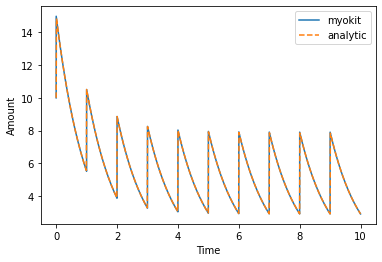

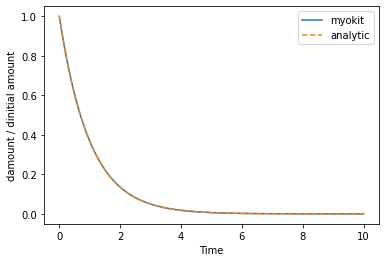

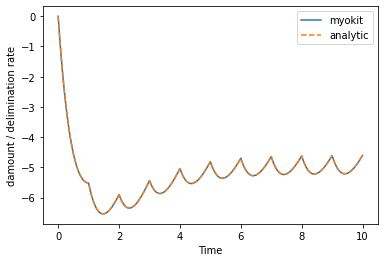

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Solve with myokit
sensitivities = (
    ['myokit.amount'],
    ['init(myokit.amount)', 'myokit.elimination_rate'])
amount = 5
duration = 0.001
protocol = myokit.pacing.blocktrain(1, duration, offset=0, level=amount/duration, limit=0)
sim = myokit.Simulation(model, protocol, sensitivities)

myokit_solution, myokit_partials = sim.run(10)
myokit_partials = np.array(myokit_partials)[:, 0, :]

# Solve analytically
times = np.linspace(0, 10, 1000)
parameters = [10, 1, amount / duration, duration]
analytic_solution = solve_amount(parameters, times)
analytic_partials = solve_partials(parameters, times)

# Plot results
plt.figure()
plt.plot(myokit_solution.time(), myokit_solution['myokit.amount'], label='myokit')
plt.plot(times, analytic_solution, label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 0], label='myokit')
plt.plot(times, analytic_partials[0, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / dinitial amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 1], label='myokit')
plt.plot(times, analytic_partials[1, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / delimination rate')
plt.legend()
plt.show()

### Large duration

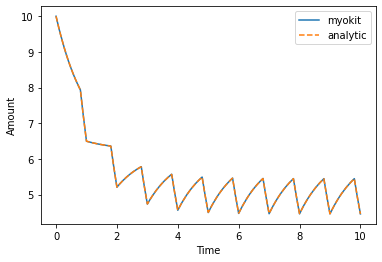

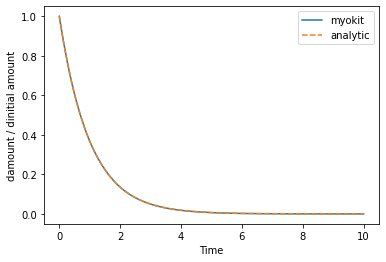

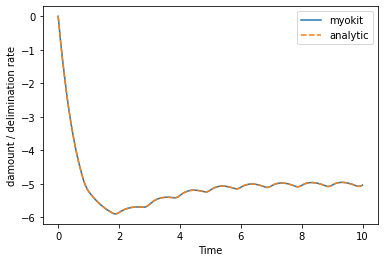

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Solve with myokit
sensitivities = (
    ['myokit.amount'],
    ['init(myokit.amount)', 'myokit.elimination_rate'])
amount = 5
duration = 0.8
protocol = myokit.pacing.blocktrain(1, duration, offset=0, level=amount/duration, limit=0)
sim = myokit.Simulation(model, protocol, sensitivities)

myokit_solution, myokit_partials = sim.run(10)
myokit_partials = np.array(myokit_partials)[:, 0, :]

# Solve analytically
times = np.linspace(0, 10, 1000)
parameters = [10, 1, amount / duration, duration]
analytic_solution = solve_amount(parameters, times)
analytic_partials = solve_partials(parameters, times)

# Plot results
plt.figure()
plt.plot(myokit_solution.time(), myokit_solution['myokit.amount'], label='myokit')
plt.plot(times, analytic_solution, label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 0], label='myokit')
plt.plot(times, analytic_partials[0, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / dinitial amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 1], label='myokit')
plt.plot(times, analytic_partials[1, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / delimination rate')
plt.legend()
plt.show()

### Intermediate duration (such that infusion cancels elimination)

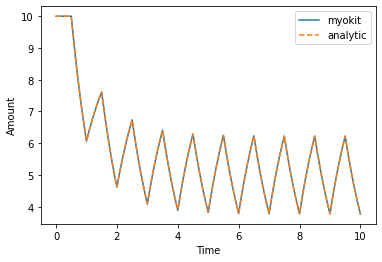

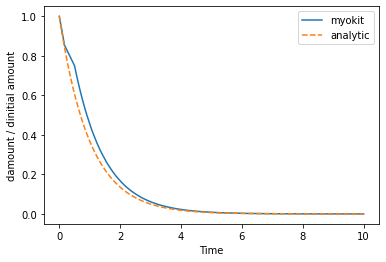

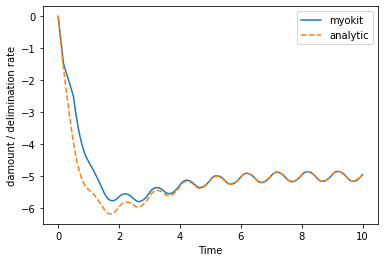

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Solve with myokit
sensitivities = (
    ['myokit.amount'],
    ['init(myokit.amount)', 'myokit.elimination_rate'])
amount = 5
duration = 0.5
protocol = myokit.pacing.blocktrain(1, duration, offset=0, level=amount/duration, limit=0)
sim = myokit.Simulation(model, protocol, sensitivities)

myokit_solution, myokit_partials = sim.run(10)
myokit_partials = np.array(myokit_partials)[:, 0, :]

# Solve analytically
times = np.linspace(0, 10, 1000)
parameters = [10, 1, amount / duration, duration]
analytic_solution = solve_amount(parameters, times)
analytic_partials = solve_partials(parameters, times)

# Plot results
plt.figure()
plt.plot(myokit_solution.time(), myokit_solution['myokit.amount'], label='myokit')
plt.plot(times, analytic_solution, label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 0], label='myokit')
plt.plot(times, analytic_partials[0, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / dinitial amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 1], label='myokit')
plt.plot(times, analytic_partials[1, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / delimination rate')
plt.legend()
plt.show()

### Zoom into ciritcal region

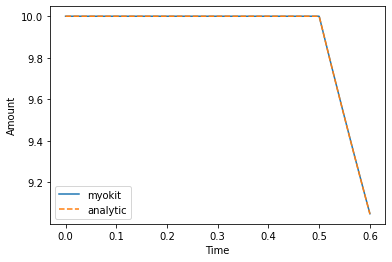

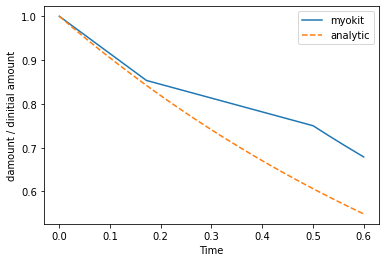

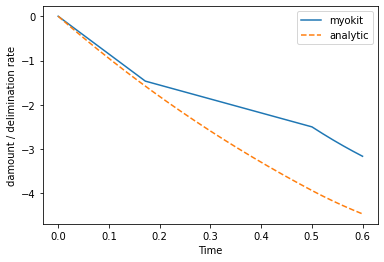

In [29]:
# Solve with myokit
times = np.linspace(0, 0.6, 1000)
sensitivities = (
    ['myokit.amount'],
    ['init(myokit.amount)', 'myokit.elimination_rate'])
amount = 5
duration = 0.5
protocol = myokit.pacing.blocktrain(1, duration, offset=0, level=amount/duration, limit=0)
sim = myokit.Simulation(model, protocol, sensitivities)

myokit_solution, myokit_partials = sim.run(10, log_times=times)
myokit_partials = np.array(myokit_partials)[:, 0, :]

# Solve analytically
parameters = [10, 1, amount / duration, duration]
analytic_solution = solve_amount(parameters, times)
analytic_partials = solve_partials(parameters, times)

# Plot results
plt.figure()
plt.plot(myokit_solution.time(), myokit_solution['myokit.amount'], label='myokit')
plt.plot(times, analytic_solution, label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 0], label='myokit')
plt.plot(times, analytic_partials[0, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / dinitial amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 1], label='myokit')
plt.plot(times, analytic_partials[1, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / delimination rate')
plt.legend()
plt.show()

### Tighter accuracy bounds

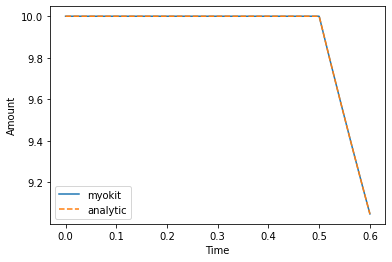

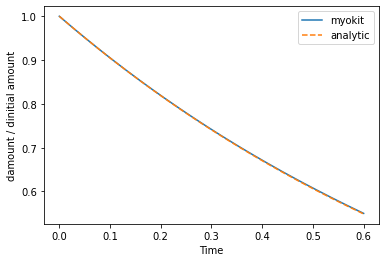

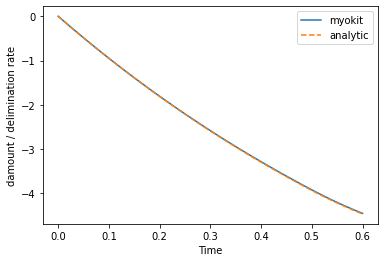

In [38]:
# Solve with myokit
times = np.linspace(0, 0.6, 1000)
sensitivities = (
    ['myokit.amount'],
    ['init(myokit.amount)', 'myokit.elimination_rate'])
amount = 5
duration = 0.5
protocol = myokit.pacing.blocktrain(1, duration, offset=0, level=amount/duration, limit=0)
sim = myokit.Simulation(model, protocol, sensitivities)
sim.set_tolerance(abs_tol=1e-10, rel_tol=1e-10)

myokit_solution, myokit_partials = sim.run(10, log_times=times)
myokit_partials = np.array(myokit_partials)[:, 0, :]

# Solve analytically
parameters = [10, 1, amount / duration, duration]
analytic_solution = solve_amount(parameters, times)
analytic_partials = solve_partials(parameters, times)

# Plot results
plt.figure()
plt.plot(myokit_solution.time(), myokit_solution['myokit.amount'], label='myokit')
plt.plot(times, analytic_solution, label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 0], label='myokit')
plt.plot(times, analytic_partials[0, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / dinitial amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 1], label='myokit')
plt.plot(times, analytic_partials[1, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / delimination rate')
plt.legend()
plt.show()

### Slight deviation from this point

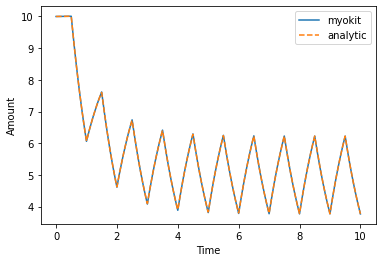

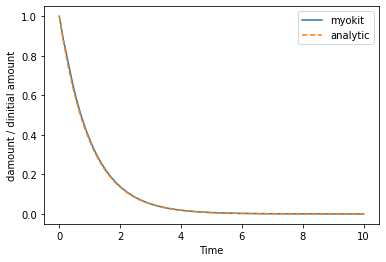

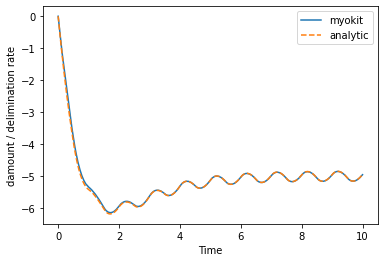

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Solve with myokit
sensitivities = (
    ['myokit.amount'],
    ['init(myokit.amount)', 'myokit.elimination_rate'])
amount = 5
duration = 0.499
protocol = myokit.pacing.blocktrain(1, duration, offset=0, level=amount/duration, limit=0)
sim = myokit.Simulation(model, protocol, sensitivities)

myokit_solution, myokit_partials = sim.run(10)
myokit_partials = np.array(myokit_partials)[:, 0, :]

# Solve analytically
times = np.linspace(0, 10, 1000)
parameters = [10, 1, amount / duration, duration]
analytic_solution = solve_amount(parameters, times)
analytic_partials = solve_partials(parameters, times)

# Plot results
plt.figure()
plt.plot(myokit_solution.time(), myokit_solution['myokit.amount'], label='myokit')
plt.plot(times, analytic_solution, label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 0], label='myokit')
plt.plot(times, analytic_partials[0, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / dinitial amount')
plt.legend()
plt.show()

plt.figure()
plt.plot(myokit_solution.time(), myokit_partials[:, 1], label='myokit')
plt.plot(times, analytic_partials[1, :], label='analytic', linestyle='--')
plt.xlabel('Time')
plt.ylabel('damount / delimination rate')
plt.legend()
plt.show()